In [1]:
import copy
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.nn import FFNN

In [2]:
DATA = '../daily/data'
N_MODS = 3

Mutate: False


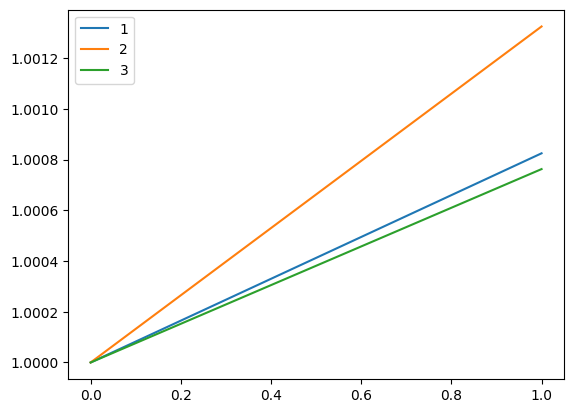

In [3]:
N_NEEDED = 6

perf1 = np.array([100673,100756])
perf2 = np.array([ 99670, 99802])
perf3 = np.array([ 99704, 99780])

MUTATE = len(perf1) - 1 >= N_NEEDED
print('Mutate:', MUTATE)

buying_power = [114227, 119427, 1201091]

plt.plot(perf1 / perf1[0], label='1')
plt.plot(perf2 / perf2[0], label='2')
plt.plot(perf3 / perf3[0], label='3')
plt.legend();

In [4]:
BEST = 1  # [1, 2, 3]
MUTATE_SCALE = 0.45  # x0.9 or x1.1

In [5]:
metrics = pd.read_csv(f'{DATA}/stock_metrics.csv')
metrics.head()

,stock,price,direction,RSI,RSIRev,fair_value_mult,geomean,sharpe
0,AAON,79.650002,0,0.086731,0.913269,0.110493,0.005435,0.651737
1,AAPL,218.270004,0,0.135092,0.864908,0.187599,0.097408,0.859730
2,ABNB,128.800003,0,0.321698,0.678302,0.325885,0.294737,0.188013
3,ACN,305.320007,0,0.009193,0.990807,0.030207,0.039298,0.673156
4,ADBE,387.260010,0,0.038769,0.961231,0.069157,0.046823,0.654692


In [6]:
x = metrics[['direction', 'RSI', 'fair_value_mult', 'geomean', 'sharpe']]

In [7]:
states = [None] * N_MODS
try:
    with open(f'{DATA}/ffnn_states.pkl', 'rb') as f:
        states = pickle.load(f)
        print('States recovered')
except FileNotFoundError:
    print('Creating new states...')
    states = [None] * N_MODS

States recovered


In [8]:
len(states)

3

In [9]:
mods = []
for state in states:
    mod = FFNN(**state) if state is not None else FFNN(5, [5])
    mods.append(mod)

In [10]:
if MUTATE:
    print('mutating..')
    best_state = mods[BEST - 1].get_state()
    mods = [mods[BEST - 1]]

    for _ in range(1, N_MODS):
        new_mod = FFNN(**copy.deepcopy(best_state))
        new_mod.mutate(scale=MUTATE_SCALE)
        mods.append(new_mod)
else:
    print('do nothing')

do nothing


In [11]:
len(mods)

3

In [12]:
#for mod in mods:
#    print(mod.Ws)

In [13]:
def get_holdings(filename, i):
    df = pd.read_csv(f'~/Downloads/ffnn/{filename}')
    df = df[['Symbol', 'Value']]
    df.Value = df.Value.str.replace('$', '').str.replace(',', '').astype(float)
    df.columns = ['stock', f'holdings{i + 1}']
    df.set_index('stock', drop=True, inplace=True)
    return df

In [14]:
holdings_files = sorted([f for f in os.listdir('/Users/damiansp/Downloads/ffnn') if f.endswith('.csv')])
holdings = pd.concat([get_holdings(f, i) for i, f in enumerate(holdings_files)], axis=1)
holdings.fillna(0, inplace=True)
holdings.head()

,holdings1,holdings2,holdings3
stock,,,
AAON,1194.75,1035.45,0.00
AAPL,873.08,654.81,873.08
ABBV,630.03,630.03,840.04
ABT,505.36,0.00,0.00
ACN,915.96,1221.28,915.96


In [15]:
out = pd.DataFrame({'stock': metrics.stock, 'price': metrics.price.round(2)})
cols = []
for i, mod in enumerate(mods):
    value = mod.forward_pass(x, 'relu', 'sigmoid')
    value = value.squeeze()
    value /= np.sum(value)
    col = pd.Series(value, name=f'val{i + 1}')
    cols.append(col)
out = pd.concat([out, *cols], axis=1)
out.head()

,stock,price,val1,val2,val3
0,AAON,79.65,0.005713,0.005343,0.005308
1,AAPL,218.27,0.005795,0.005359,0.005354
2,ABNB,128.80,0.004819,0.005214,0.005142
3,ACN,305.32,0.005772,0.005351,0.005337
4,ADBE,387.26,0.005746,0.005347,0.005325


In [16]:
for h in [1, 2, 3]:
    invested_amt = holdings[f'holdings{h}'].sum()
    buying_power[h - 1] += invested_amt
print(buying_power)
amt_in = []
for i, d in enumerate(buying_power):
    amt = (d * out[f'val{i + 1}']).round(2)
    amt_in.append(pd.Series(amt, name=f'amt{i + 1}'))
out = pd.concat([out, *amt_in], axis=1)
out.set_index('stock', inplace=True, drop=True)
out.head()

[201512.59, 199602.92, 1280542.92]


,price,val1,val2,val3,amt1,amt2,amt3
stock,,,,,,,
AAON,79.65,0.005713,0.005343,0.005308,1151.22,1066.40,6797.55
AAPL,218.27,0.005795,0.005359,0.005354,1167.77,1069.62,6855.55
ABNB,128.80,0.004819,0.005214,0.005142,971.01,1040.72,6584.61
ACN,305.32,0.005772,0.005351,0.005337,1163.15,1068.00,6833.94
ADBE,387.26,0.005746,0.005347,0.005325,1157.84,1067.24,6818.25


In [17]:
out = pd.concat([out, holdings], axis=1)
out.fillna(0, inplace=True)
out.head()

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3
stock,,,,,,,,,,
AAON,79.65,0.005713,0.005343,0.005308,1151.22,1066.40,6797.55,1194.75,1035.45,0.00
AAPL,218.27,0.005795,0.005359,0.005354,1167.77,1069.62,6855.55,873.08,654.81,873.08
ABNB,128.80,0.004819,0.005214,0.005142,971.01,1040.72,6584.61,0.00,0.00,0.00
ACN,305.32,0.005772,0.005351,0.005337,1163.15,1068.00,6833.94,915.96,1221.28,915.96
ADBE,387.26,0.005746,0.005347,0.005325,1157.84,1067.24,6818.25,1161.78,387.26,1161.78


In [18]:
for i in range(N_MODS):
    out[f'diff{i + 1}'] = out[f'amt{i + 1}'] - out[f'holdings{i + 1}']
out.head()

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3,diff1,diff2,diff3
stock,,,,,,,,,,,,,
AAON,79.65,0.005713,0.005343,0.005308,1151.22,1066.40,6797.55,1194.75,1035.45,0.00,-43.53,30.95,6797.55
AAPL,218.27,0.005795,0.005359,0.005354,1167.77,1069.62,6855.55,873.08,654.81,873.08,294.69,414.81,5982.47
ABNB,128.80,0.004819,0.005214,0.005142,971.01,1040.72,6584.61,0.00,0.00,0.00,971.01,1040.72,6584.61
ACN,305.32,0.005772,0.005351,0.005337,1163.15,1068.00,6833.94,915.96,1221.28,915.96,247.19,-153.28,5917.98
ADBE,387.26,0.005746,0.005347,0.005325,1157.84,1067.24,6818.25,1161.78,387.26,1161.78,-3.94,679.98,5656.47


In [19]:
out = out[((out.price.notnull()) & (out.price > 0))]

In [20]:
for i in range(N_MODS):
    out[f'shares{i + 1}'] = (out[f'diff{i + 1}'] / out.price).round().astype('Int64')
out = out[out.price >= 2]
out

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3,diff1,diff2,diff3,shares1,shares2,shares3
stock,,,,,,,,,,,,,,,,
AAON,79.65,0.005713,0.005343,0.005308,1151.22,1066.40,6797.55,1194.75,1035.45,0.00,-43.53,30.95,6797.55,-1,0,85
AAPL,218.27,0.005795,0.005359,0.005354,1167.77,1069.62,6855.55,873.08,654.81,873.08,294.69,414.81,5982.47,1,2,27
ABNB,128.80,0.004819,0.005214,0.005142,971.01,1040.72,6584.61,0.00,0.00,0.00,971.01,1040.72,6584.61,8,8,51
ACN,305.32,0.005772,0.005351,0.005337,1163.15,1068.00,6833.94,915.96,1221.28,915.96,247.19,-153.28,5917.98,1,-1,19
ADBE,387.26,0.005746,0.005347,0.005325,1157.84,1067.24,6818.25,1161.78,387.26,1161.78,-3.94,679.98,5656.47,0,2,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VTRS,9.15,0.002233,0.003882,0.004487,450.01,774.80,5745.79,0.00,0.00,0.00,450.01,774.80,5745.79,49,85,628
WING,215.46,0.005776,0.005353,0.005361,1164.03,1068.54,6864.82,861.84,861.84,861.84,302.19,206.70,6002.98,1,1,28
WIT,3.03,0.003690,0.004797,0.004921,743.49,957.40,6301.05,0.00,0.00,0.00,743.49,957.40,6301.05,245,316,2080


In [21]:
o = out.sort_values('diff1', ascending=False)[['price', 'diff1', 'shares1']]
o[o.shares1 != 0].head(5)

,price,diff1,shares1
stock,,,
QBTS,8.36,1173.77,140
BLD,298.52,1158.55,4
TDG,1346.12,1157.36,1
VLTO,97.77,1150.63,12
ASML,716.22,1149.11,2


In [22]:
o[o.shares1 != 0].tail(5)

,price,diff1,shares1
stock,,,
MCD,305.44,249.72,1
ACN,305.32,247.19,1
APO,143.41,223.97,2
SMLR,39.22,102.86,3
AAON,79.65,-43.53,-1


In [23]:
o = out.sort_values('diff2', ascending=False)[['price', 'diff2', 'shares2']]
o[o.shares2 != 0].head(5)

,price,diff2,shares2
stock,,,
QBTS,8.36,1070.35,128
MCK,661.17,1068.11,2
VRTX,503.20,1068.01,2
ASML,716.22,1067.98,1
BABA,135.14,1067.78,8


In [25]:
o[o.shares2 != 0].tail(5)

,price,diff2,shares2
stock,,,
SMLR,39.22,-73.69,-2
TJX,116.12,-94.32,-1
DGX,167.11,-100.99,-1
FIVN,30.14,-107.17,-4
ACN,305.32,-153.28,-1


In [26]:
o = out.sort_values('diff3', ascending=False)[['price', 'diff3', 'shares3']]
o[o.shares3 != 0].head(5)

,price,diff3,shares3
stock,,,
CB,291.43,6848.93,24
IEFA,77.56,6833.41,88
MDT,90.33,6829.40,76
CDW,165.57,6827.59,41
ASML,716.22,6822.61,10


In [28]:
o[o.shares3 != 0].tail(5)

,price,diff3,shares3
stock,,,
SAIA,362.90,5711.31,16
SPY,563.98,5708.05,10
ADBE,387.26,5656.47,15
TDG,1346.12,5524.59,4
MELI,2095.27,4787.04,2


In [29]:
if MUTATE:
    states = [mod.get_state() for mod in mods]
    with open(f'{DATA}/ffnn_states.pkl', 'wb') as f:
        pickle.dump(states, f)
    print('States saved')
else:
    print('Did nothing')

Did nothing


In [32]:
df = pd.DataFrame({'a': [1, 2, None], 'b': [np.nan] * 3, 'c': [1, 3, 4]})

In [33]:
df

,a,b,c
0,1.0,NaN,1
1,2.0,NaN,3
2,NaN,NaN,4


In [34]:
df.loc[:, df.isnull().sum() < len(df)]

,a,c
0,1.0,1
1,2.0,3
2,NaN,4
